# Sign Detection with Convolutional Neural Network

### Loading Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.models import Model
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import classification_report

import seaborn as sns
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Image Data Augmentation

In [2]:
# ImageDataGenerator
datagen = ImageDataGenerator(
    validation_split=0.2,
         rotation_range=10, # rotation
         width_shift_range=0.2, # horizontal shift
         height_shift_range=0.2, # vertical shift
         zoom_range=0.2, # zoom
         horizontal_flip=True, # horizontal flip
         brightness_range=[0.2,1.2]) # brightness

data_dir = "ISL-Original/Training"
test_datagen=ImageDataGenerator(validation_split=0.2)
train_ds = datagen.flow_from_directory(data_dir,
                                           class_mode = 'categorical',
                                           target_size = (28, 28),
                                           batch_size=128,
                                       subset='training',
                                           seed=46)
val_ds = test_datagen.flow_from_directory(data_dir,
                                     class_mode = 'categorical',
                                     target_size = (28, 28),
                                     batch_size=128,
                                          subset='validation',
                                     seed=46)

Found 8803 images belonging to 26 classes.
Found 2189 images belonging to 26 classes.


### Declare Metrics 

In [3]:
from tensorflow.keras import backend as K
def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

### Implement the Deep Learning Model - MobileNet

In [4]:
model=Sequential()

# model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,3)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(26,activation="softmax"))
    

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0

In [7]:
#fit the model
#it will take some time to train
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics = ['accuracy',f1, precision,recall])
history = model.fit(train_ds, epochs =10, batch_size = 128,validation_data=val_ds)

Epoch 1/10
69/69 [==============================] - 75s 1s/step - loss: 2.0598 - accuracy: 0.3988 - f1: 0.2581 - precision: 0.7249 - recall: 0.1720 - val_loss: 2.1577 - val_accuracy: 0.3961 - val_f1: 0.3918 - val_precision: 0.5756 - val_recall: 0.2980
Epoch 2/10
69/69 [==============================] - 73s 1s/step - loss: 0.8020 - accuracy: 0.7656 - f1: 0.7307 - precision: 0.8846 - recall: 0.6291 - val_loss: 3.4477 - val_accuracy: 0.3371 - val_f1: 0.3535 - val_precision: 0.3953 - val_recall: 0.3200
Epoch 3/10
69/69 [==============================] - 73s 1s/step - loss: 0.4038 - accuracy: 0.8798 - f1: 0.8758 - precision: 0.9311 - recall: 0.8275 - val_loss: 0.4802 - val_accuracy: 0.8342 - val_f1: 0.8396 - val_precision: 0.8855 - val_recall: 0.7987
Epoch 4/10
69/69 [==============================] - 74s 1s/step - loss: 0.2567 - accuracy: 0.9225 - f1: 0.9210 - precision: 0.9499 - recall: 0.8941 - val_loss: 0.4085 - val_accuracy: 0.8488 - val_f1: 0.8503 - val_precision: 0.8882 - val_recall:

### Learning Curves - Graph 

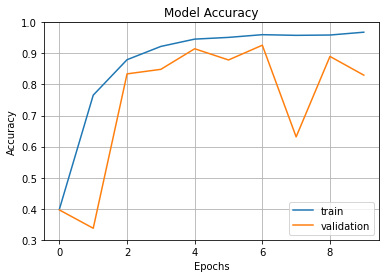

In [10]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.3,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

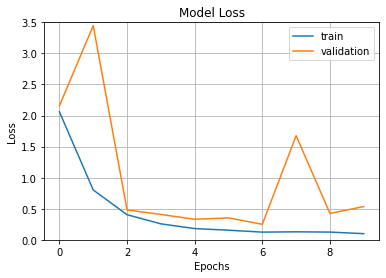

In [18]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=3.5)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Evaluating the Model 

In [19]:
Y_pred = model.predict_generator(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

Text(0.5, 33.0, 'Predicted label')

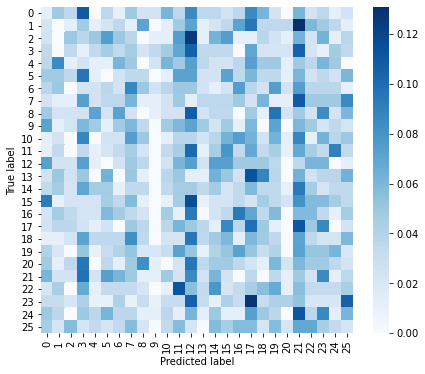

In [20]:
cf_mat = confusion_matrix(val_ds.classes, y_pred)
cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 6))
sns.heatmap(cf_mat_normalized, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [21]:
model.save('cnn_signd.h5')

In [22]:
labels = val_ds.classes
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.01      0.01        82
           1       0.00      0.00      0.00        84
           2       0.08      0.05      0.06        80
           3       0.01      0.01      0.01        85
           4       0.02      0.01      0.02        82
           5       0.00      0.00      0.00        83
           6       0.03      0.03      0.03        80
           7       0.05      0.06      0.05        82
           8       0.00      0.00      0.00        83
           9       0.00      0.00      0.00        84
          10       0.01      0.01      0.01        80
          11       0.04      0.05      0.04        88
          12       0.04      0.07      0.05        82
          13       0.02      0.01      0.02        79
          14       0.05      0.05      0.05        85
          15       0.02      0.02      0.02        86
          16       0.10      0.09      0.10        85
          17       0.06    

['Z']

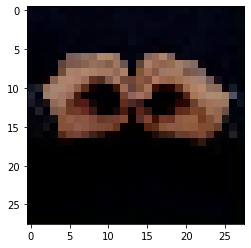

In [33]:
#Creating a dictionary to map each of the indexes to the corresponding number or letter
from keras.preprocessing import image
dict = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",
        11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",
        24:"Y",25:"Z"}


#Predicting images

img = image.load_img("sign_B2.jpg", target_size=(28, 28))
x = image.img_to_array(img)
plt.imshow(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = model.predict(image, batch_size=64)
label = [np.argmax(i) for i in classes]
pred_class=[dict[x] for x in label]
pred_class

In [34]:
loss, accuracy, f1_score, precision, recall = model.evaluate(val_ds, verbose=0)

In [35]:
print(f"Test Loss: ", loss)
print(f"Test Accuracy: ", accuracy)
print(f"Test Precision: ", precision)
print(f"Test Recall: ",recall)
print(f"Test F1 Score: ",f1_score)

Test Loss:  0.5349419713020325
Test Accuracy:  0.8300594091415405
Test Precision:  0.8525751233100891
Test Recall:  0.8221153616905212
Test F1 Score:  0.8369857668876648


In [36]:
print(f"Test Loss: ", round(loss*100, 3), '%')
print(f"Test Accuracy: ", round(accuracy*100, 3), '%')
print(f"Test Precision: ", round(precision*100, 3), '%')
print(f"Test Recall: ",round(recall*100, 3), '%')
print(f"Test F1 Score: ",round(f1_score*100, 3), '%')

Test Loss:  53.494 %
Test Accuracy:  83.006 %
Test Precision:  85.258 %
Test Recall:  82.212 %
Test F1 Score:  83.699 %
